# Introduction

Make figures for paper


### Figure 1

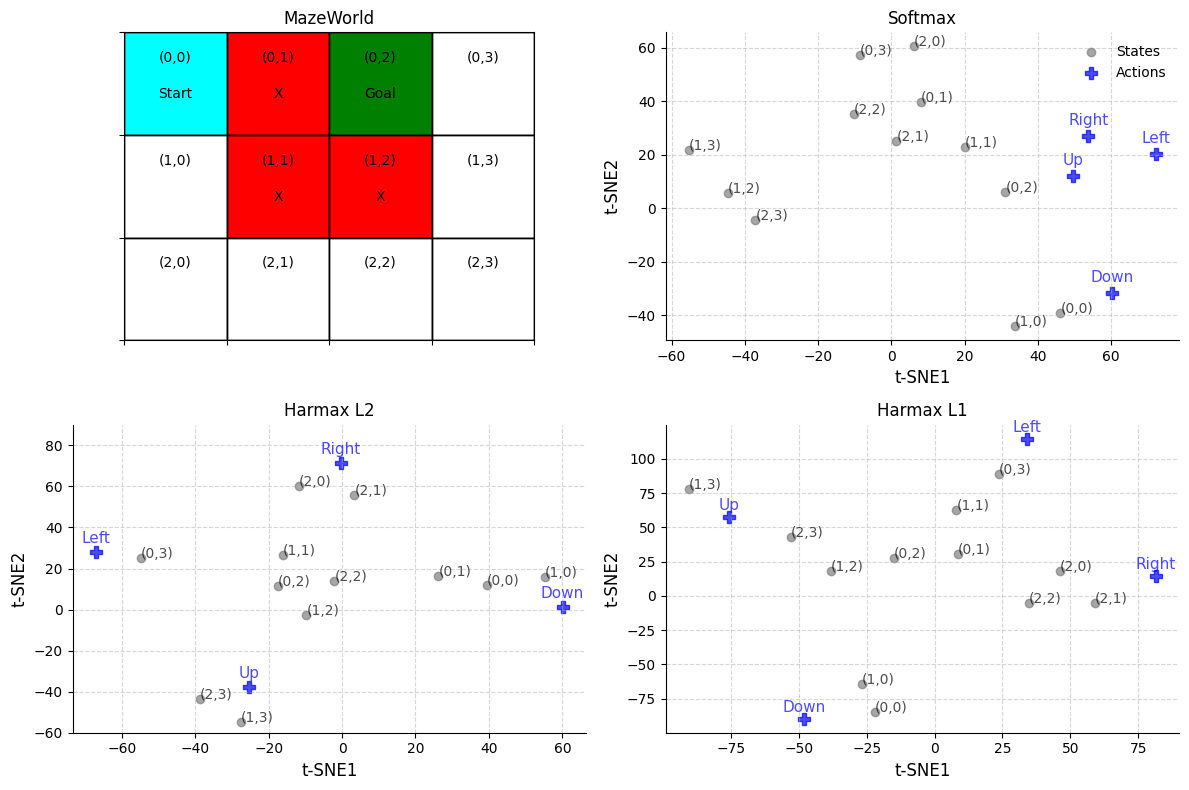

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_env_render(ax):
    """
    Improved environment rendering in matplotlib that mimics a grid with:
      - Obstacles (X) in red,
      - Start (S) in cyan,
      - Goal (G) in green,
      - Agent (A) in yellow,
      - Empty cells (.) in white.
    Each cell is labeled with its (row, col) coordinates.
    """
    grid_size = (3, 4)  # Example grid of 3 rows and 4 columns
    grid = [
        ['Start', 'X', 'Goal', ''],
        ['', 'X', 'X', ''],
        ['', '', '', '']
    ]
    
    obstacles = set()
    start = (0, 0)
    goal = (0, 2)
    agent = (2, 1)
    
    H, W = grid_size
    ax.set_xlim(0, W)
    ax.set_ylim(0, H)
    ax.set_xticks(np.arange(W+1))
    ax.set_yticks(np.arange(H+1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.invert_yaxis()  # so row=0 is at the top
    ax.set_aspect('equal', 'box')
    ax.set_title("MazeWorld")
    ax.grid(color='black', linestyle='-', linewidth=1)

    for r in range(H):
        for c in range(W):
            cell = grid[r][c]
            if cell == 'X':
                facecolor = 'red'
            elif (r, c) == start:
                facecolor = 'cyan'
            elif (r, c) == goal:
                facecolor = 'green'
            # elif (r, c) == agent:
            #     facecolor = 'yellow'
            else:
                facecolor = 'white'

            rect = plt.Rectangle((c, r), 1, 1, facecolor=facecolor, edgecolor='black')
            ax.add_patch(rect)
            ax.text(c+0.5, r+0.6, cell, ha='center', va='center', fontsize=10, color='black')
            ax.text(c+0.5, r+0.25, f"({r},{c})", ha='center', va='center', fontsize=10, color='black')




# Directory where embeddings are saved
embeddings_dir = './embeddings/mazeworld'

# Define the approaches for which you saved embeddings
approaches = ['softmax', 'harmonic (L2)', 'harmonic (L1)']

# Create subplots for each approach (2 rows, 2 columns)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Define action labels (moves)
moves = {0: "Left", 1: "Right", 2: "Down", 3: "Up"}

plot_env_render(axs[0, 0])

rs = [[0,1], [1,0], [1,1]]


# Loop through each approach, load the embeddings, apply t-SNE, and plot them
for i, approach in enumerate(approaches):
    try:
        # Load the raw state and action embeddings for the current approach
        states_embeddings = np.load(os.path.join(embeddings_dir, f'{approach}_states_embeddings.npy'))
        actions_embeddings = np.load(os.path.join(embeddings_dir, f'{approach}_actions_embeddings.npy'))

        # Combine the embeddings for dimensionality reduction
        combined_embeddings = np.vstack([states_embeddings, actions_embeddings])

        # Apply t-SNE to the combined embeddings
        tsne = TSNE(n_components=2, random_state=42, perplexity=5)
        combined_tsne = tsne.fit_transform(combined_embeddings)

        # Split the t-SNE result back into states and actions
        states_tsne = combined_tsne[:states_embeddings.shape[0]]
        actions_tsne = combined_tsne[states_embeddings.shape[0]:]

        # KL Divergence
        kl_divergence = tsne.kl_divergence_

        # Determine row, column for subplot (i)
        row, col = rs[i]

        # Plot the embeddings
        axs[row, col].scatter(states_tsne[:, 0], states_tsne[:, 1], color='gray', alpha=0.7, label='States')
        axs[row, col].scatter(actions_tsne[:, 0], actions_tsne[:, 1], color='blue', alpha=0.7, label='Actions', s=85,
        marker='P')

        # Label each state with (x, y) coordinates
        for j, (x, y) in enumerate(states_tsne):
            axs[row, col].text(x, y, f"({j//4},{j%4})", fontsize=10, alpha=0.7)  # Assuming grid is 4x4, adjust as needed

        # Label each action with its move
        for j, (x, y) in enumerate(actions_tsne):
            action_label = moves.get(j, f"A{j}")
            axs[row, col].text(x, y+3, f"{action_label}", fontsize=11, alpha=0.7, color='blue',ha='center', va='bottom')


        approach_titles = {
            'harmonic (L2)': 'Harmax L2',
            'harmonic (L1)': 'Harmax L1',
            'softmax': 'Softmax'
        }
        axs[row, col].set_title(f'{approach_titles.get(approach, approach.capitalize())}')
        #axs[row, col].set_title(f'{approach.capitalize()}')
        #axs[row, col].set_title(f'{approach.capitalize()} (KL Divergence={kl_divergence:.2f})')
        axs[row, col].set_xlabel('t-SNE1')
        axs[row, col].set_ylabel('t-SNE2')
        if i == 0:
            axs[row, col].legend()
        if i == 1:
            axs[row, col].set_ylim([-60,90])
        axs[row, col].grid(True, linestyle='--', alpha=0.5)
        axs[row, col].spines['top'].set_color('none')
        axs[row, col].spines['right'].set_color('none')
        #axs[row, col].set_axisbelow(True)  # Ensures axes are on top of the plot


    except Exception as e:
        print(f"Error loading embeddings for {approach}: {e}")

# Show the plots
plt.tight_layout()
plt.savefig('figures/final/embedding_mazeworld.png')
plt.show()

### Figure 2: learning curve gym

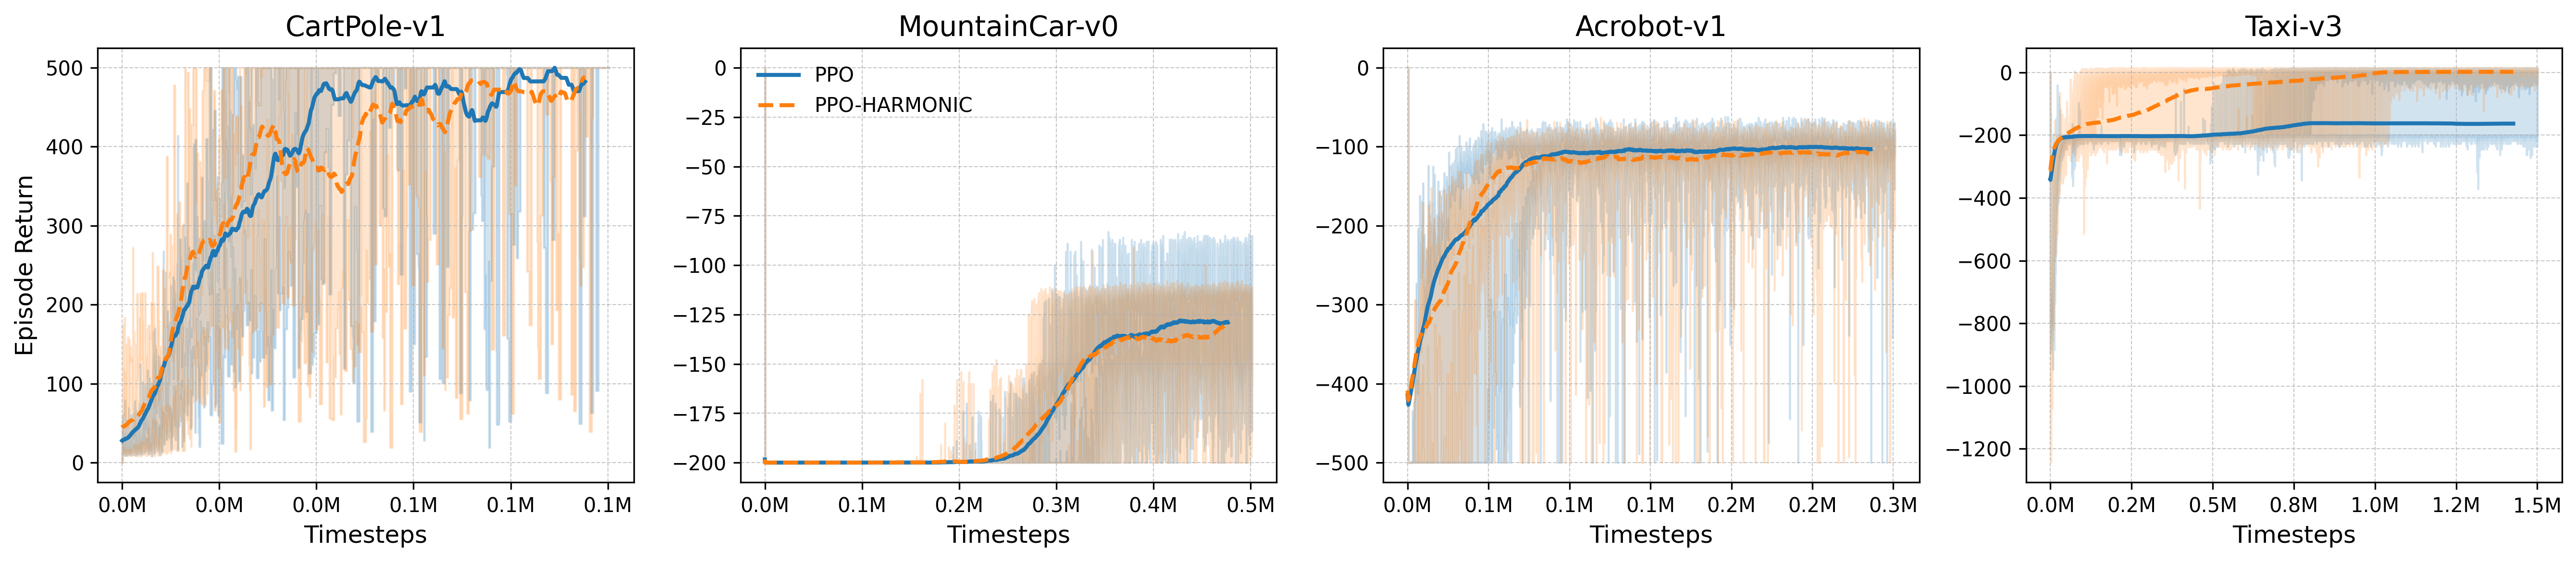

In [17]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Directory where learning data is stored
dir_data = 'models'
envs = ['CartPole-v1', 'MountainCar-v0', 'Acrobot-v1', 'Taxi-v3']

# Define colors and styles
colors = {"ppo": "#1f77b4", "ppo-harmonic": "#ff7f0e"}  # Blue and orange
linestyles = {"ppo": "-", "ppo-harmonic": "--"}  # Solid for PPO, dashed for PPO-Harmonic
window_size = 10  # Rolling average window

def rolling_average(data, window):
    """Compute rolling average with a given window size."""
    return np.convolve(data, np.ones(window)/window, mode='valid')

# Create a 1x4 subplot figure
fig, axes = plt.subplots(1, 4, figsize=(18, 4), dpi=300)  # High-res for publication

for i, env in enumerate(envs):
    path = os.path.join(dir_data, env, 'learning_data.pkl')
    
    if os.path.exists(path):
        with open(path, 'rb') as f:
            results = pickle.load(f)

        # Extract PPO and PPO-Harmonic results
        for agent_type, curves in results.items():
            run_histories = []
            max_timestep = 0

            # Find max timestep for consistent plotting
            for episode_ends, episode_returns in curves:
                if len(episode_ends) > 0:
                    max_timestep = max(max_timestep, episode_ends[-1])

            # Convert episodic returns into continuous curves
            for episode_ends, episode_returns in curves:
                hist = np.zeros(max_timestep + 1, dtype=np.float32)
                last_return = 0.0
                prev_end = 0
                for end_step, ret in zip(episode_ends, episode_returns):
                    hist[prev_end:end_step] = last_return
                    last_return = ret
                    prev_end = end_step
                hist[prev_end:] = last_return
                run_histories.append(hist)

            # Compute mean ± min/max curves
            run_histories = np.array(run_histories, dtype=np.float32)
            mean_hist = run_histories.mean(axis=0)
            min_hist = run_histories.min(axis=0)
            max_hist = run_histories.max(axis=0)

            # Apply rolling average
            window_size = int(0.05*len(mean_hist))
            mean_hist_smoothed = rolling_average(mean_hist, window_size)
            timesteps = np.arange(len(mean_hist_smoothed))  # Adjusted for rolling window

            # Plot
            axes[i].plot(timesteps, mean_hist_smoothed, label=f"{agent_type.upper()}", 
                         color=colors[agent_type], linestyle=linestyles[agent_type], linewidth=2)
            axes[i].fill_between(np.arange(len(min_hist)), min_hist, max_hist, 
                                 color=colors[agent_type], alpha=0.2)

        # Formatting
        axes[i].set_title(env, fontsize=14)
        axes[i].set_xlabel("Timesteps", fontsize=12)
        axes[i].tick_params(axis='both', which='major', labelsize=10)
        axes[i].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))
        axes[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        if i == 1:
            axes[i].legend(fontsize=10, loc='upper left', frameon=False)
        if i == 0:
            axes[i].set_ylabel("Episode Return", fontsize=12)

# Final layout adjustments
plt.tight_layout()
plt.savefig('figures/learning_curve_gym.png', bbox_inches='tight', dpi=300)
plt.show()

### Figure3: learning curves minigrid

ValueError: too many values to unpack (expected 3)

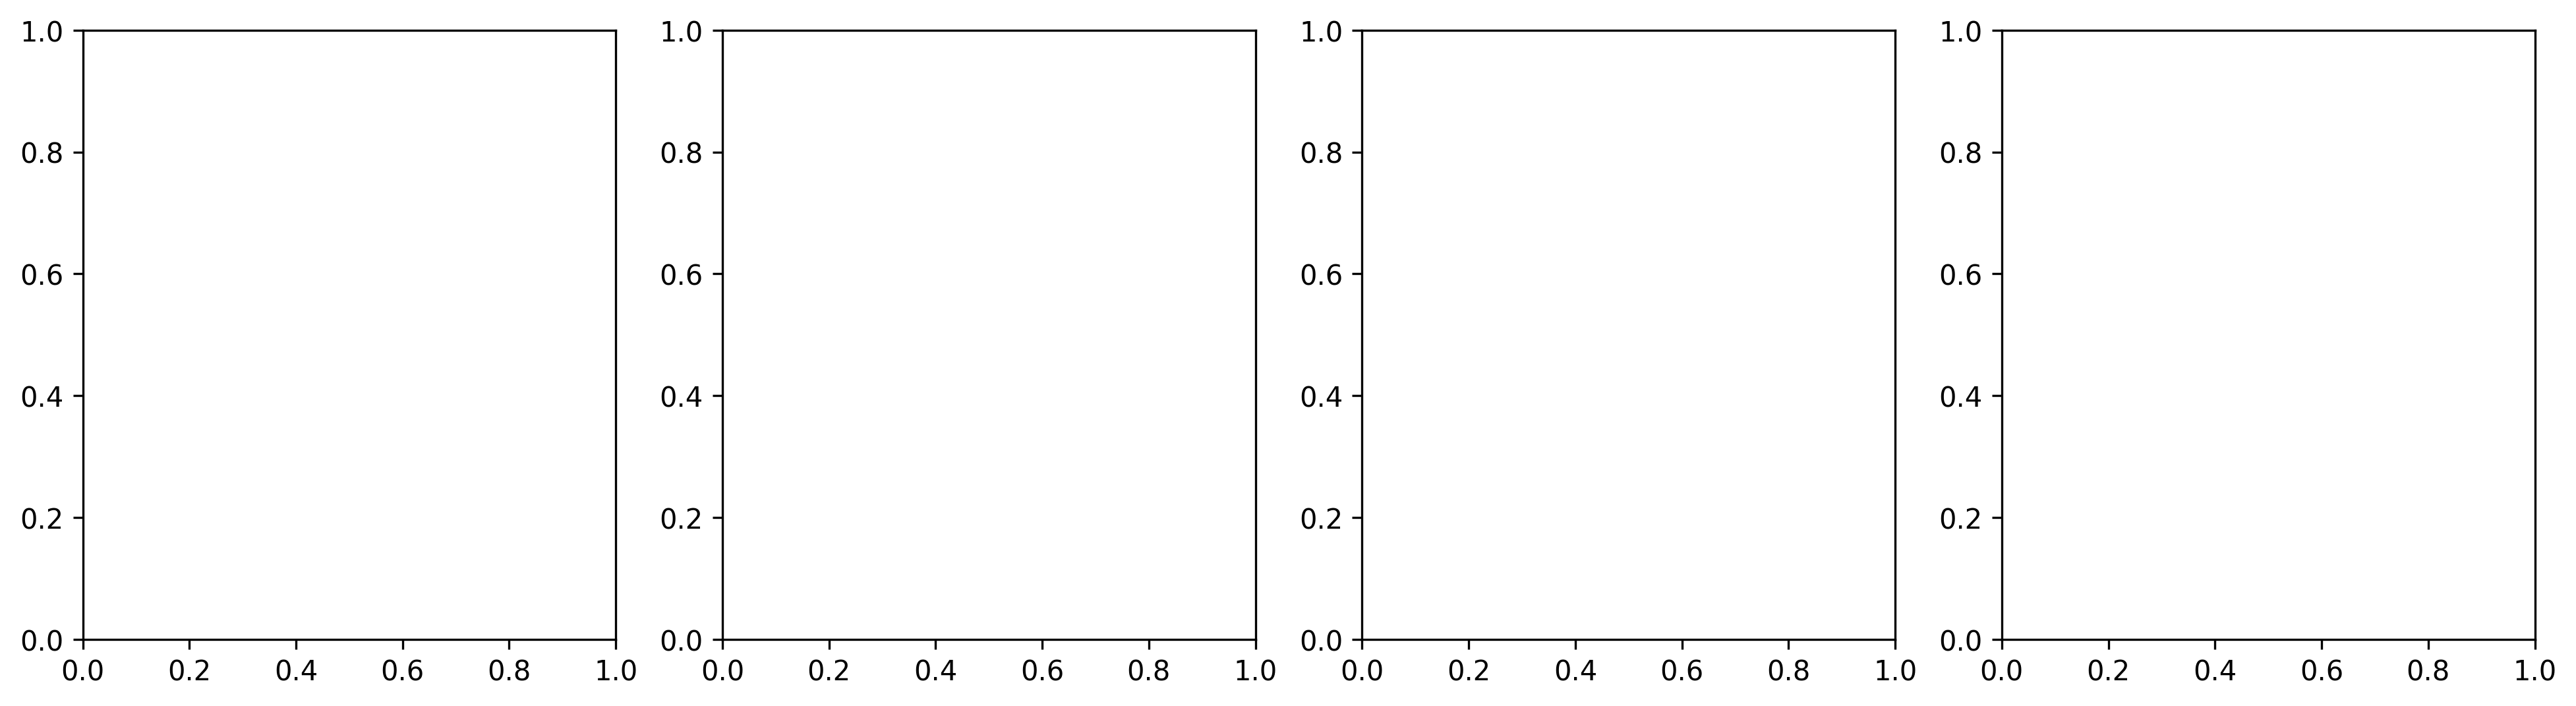

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Directory where MiniGrid/BabyAI learning data is stored
dir_data = 'models'
# envs = [
#     "MiniGrid-DoorKey-8x8-v0",     # Unlock a door with a key  
#     "MiniGrid-LockedRoom-v0",      # More complex navigation with locked doors  
#     "MiniGrid-RedBlueDoors-8x8-v0",  # Requires following a sequence of actions  
#     "MiniGrid-MultiRoom-N6-v0"     # Tests multi-room navigation  
# ]

envs = [
    'BabyAI-KeyCorridorS3R3-v0',
    'BabyAI-KeyCorridorS4R3-v0',  # no success
    'MiniGrid-DoorKey-8x8-v0',  # Corrected from "MiniGri[d..." and aligned with prior suggestion
    'BabyAI-UnlockPickup-v0'     # Added as the fourth similar environment
]

# Define colors and styles
colors = {"ppo": "#1f77b4", "ppo-harmonic": "#ff7f0e"}  # Blue and orange
linestyles = {"ppo": "-", "ppo-harmonic": "--"}  # Solid for PPO, dashed for PPO-Harmonic

def rolling_average(data, window):
    """Compute rolling average with a given window size."""
    return np.convolve(data, np.ones(window)/window, mode='valid') if len(data) > window else data

# Create a subplot figure (adjust based on number of envs)
fig, axes = plt.subplots(1, len(envs), figsize=(4 * len(envs), 4), dpi=300)  

if len(envs) == 1:
    axes = [axes]  # Ensure axes is iterable when plotting a single env

for i, env in enumerate(envs):
    path = os.path.join(dir_data, env, 'learning_data.pkl')
    
    if os.path.exists(path):
        with open(path, 'rb') as f:
            results = pickle.load(f)

        # Extract PPO and PPO-Harmonic results
        for agent_type, curves in results.items():
            run_histories = []
            max_timestep = 0

            # Read **test accuracy** (third element in the stored tuples)
            for episode_ends, _, test_acc in curves:  
                if len(episode_ends) > 0:
                    max_timestep = max(max_timestep, episode_ends[-1])

            # Convert episodic test accuracy into continuous curves
            for episode_ends, _, test_acc in curves:
                hist = np.zeros(max_timestep + 1, dtype=np.float32)
                last_acc = 0.0
                prev_end = 0
                for end_step, acc in zip(episode_ends, test_acc):
                    hist[prev_end:end_step] = last_acc
                    last_acc = acc
                    prev_end = end_step
                hist[prev_end:] = last_acc
                run_histories.append(hist)

            # Compute mean ± min/max curves
            run_histories = np.array(run_histories, dtype=np.float32)
            mean_hist = run_histories.mean(axis=0)
            min_hist = run_histories.min(axis=0)
            max_hist = run_histories.max(axis=0)

            # Apply rolling average (10% of data length, minimum 5)
            window_size = max(5, int(0.1 * len(mean_hist)))
            mean_hist_smoothed = rolling_average(mean_hist, window_size)
            timesteps = np.arange(len(mean_hist_smoothed))  # Adjusted for rolling window

            # Plot test accuracy
            axes[i].plot(timesteps, mean_hist_smoothed, label=f"{agent_type.upper()}", 
                         color=colors[agent_type], linestyle=linestyles[agent_type], linewidth=2)
            axes[i].fill_between(np.arange(len(min_hist)), min_hist, max_hist, 
                                 color=colors[agent_type], alpha=0.2)

        # Formatting
        axes[i].set_title(env.replace("MiniGrid-", "").replace("BabyAI-", ""), fontsize=14)
        axes[i].set_xlabel("Timesteps", fontsize=12)
        axes[i].tick_params(axis='both', which='major', labelsize=10)
        axes[i].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))  # Convert ticks to M
        axes[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        if i == 1:
            axes[i].legend(fontsize=10, loc='upper left', frameon=False)
        if i == 0:
            axes[i].set_ylabel("Test accuracy", fontsize=12)
        axes[i].set_ylim([0, 1])  # Success rate is always between 0 and 1

# Final layout adjustments
plt.tight_layout()
plt.savefig('figures/minigrid_learning_curves.png', bbox_inches='tight', dpi=300)
plt.show()

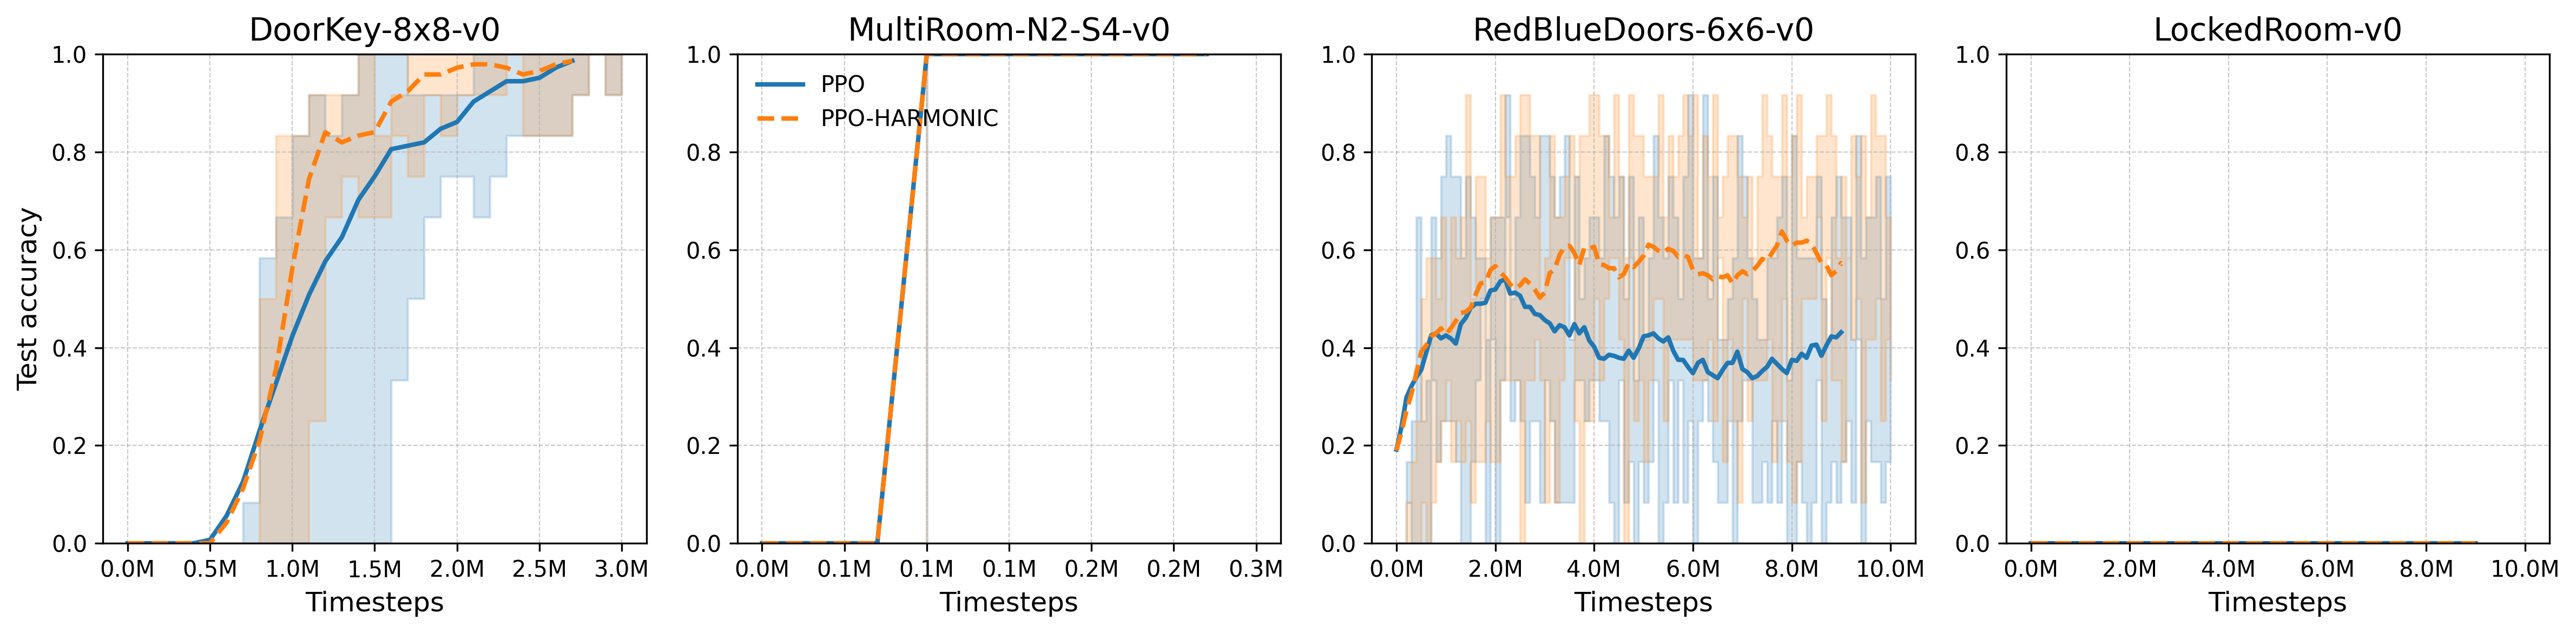

In [19]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Directory where MiniGrid/BabyAI learning data is stored
dir_data = 'models'
envs = [
    "MiniGrid-DoorKey-8x8-v0",        # Solved in 10^6 steps
    "MiniGrid-MultiRoom-N2-S4-v0",    # Smallest multi-room navigation task
    "MiniGrid-RedBlueDoors-6x6-v0",
    "MiniGrid-LockedRoom-v0",         # More complex navigation with locked doors
]

# Define colors and styles
colors = {"ppo": "#1f77b4", "ppo-harmonic": "#ff7f0e"}  # Blue and orange
linestyles = {"ppo": "-", "ppo-harmonic": "--"}  # Solid for PPO, dashed for PPO-Harmonic

def rolling_average(data, window):
    """Compute rolling average with a given window size."""
    return np.convolve(data, np.ones(window)/window, mode='valid') if len(data) > window else data

# Create a subplot figure (adjust based on number of envs)
fig, axes = plt.subplots(1, len(envs), figsize=(4 * len(envs), 4), dpi=300)  

if len(envs) == 1:
    axes = [axes]  # Ensure axes is iterable when plotting a single env

for i, env in enumerate(envs):
    path = os.path.join(dir_data, env, 'learning_data.pkl')
    
    if os.path.exists(path):
        with open(path, 'rb') as f:
            results = pickle.load(f)

        # Extract PPO and PPO-Harmonic results
        for agent_type, curves in results.items():
            run_histories = []
            max_timestep = 0

            # Read **test accuracy** (third element in the stored tuples)
            for episode_ends, _, test_acc in curves:  
                if len(episode_ends) > 0:
                    max_timestep = max(max_timestep, episode_ends[-1])

            # Convert episodic test accuracy into continuous curves
            for episode_ends, _, test_acc in curves:
                hist = np.zeros(max_timestep + 1, dtype=np.float32)
                last_acc = 0.0
                prev_end = 0
                for end_step, acc in zip(episode_ends, test_acc):
                    hist[prev_end:end_step] = last_acc
                    last_acc = acc
                    prev_end = end_step
                hist[prev_end:] = last_acc
                run_histories.append(hist)

            # Compute mean ± min/max curves
            run_histories = np.array(run_histories, dtype=np.float32)
            mean_hist = run_histories.mean(axis=0)
            min_hist = run_histories.min(axis=0)
            max_hist = run_histories.max(axis=0)

            # Apply rolling average (10% of data length, minimum 5)
            window_size = max(5, int(0.1 * len(mean_hist)))
            mean_hist_smoothed = rolling_average(mean_hist, window_size)
            timesteps = np.arange(len(mean_hist_smoothed))  # Adjusted for rolling window

            # Plot test accuracy
            axes[i].plot(timesteps, mean_hist_smoothed, label=f"{agent_type.upper()}", 
                         color=colors[agent_type], linestyle=linestyles[agent_type], linewidth=2)
            axes[i].fill_between(np.arange(len(min_hist)), min_hist, max_hist, 
                                 color=colors[agent_type], alpha=0.2)

        # Formatting
        axes[i].set_title(env.replace("MiniGrid-", "").replace("BabyAI-", ""), fontsize=14)
        axes[i].set_xlabel("Timesteps", fontsize=12)
        axes[i].tick_params(axis='both', which='major', labelsize=10)
        axes[i].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))  # Convert ticks to M
        axes[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        if i == 1:
            axes[i].legend(fontsize=10, loc='upper left', frameon=False)
        if i == 0:
            axes[i].set_ylabel("Test accuracy", fontsize=12)
        axes[i].set_ylim([0, 1])  # Success rate is always between 0 and 1

# Final layout adjustments
plt.tight_layout()
plt.savefig('figures/minigrid_learning_curves.png', bbox_inches='tight', dpi=300)
plt.show()

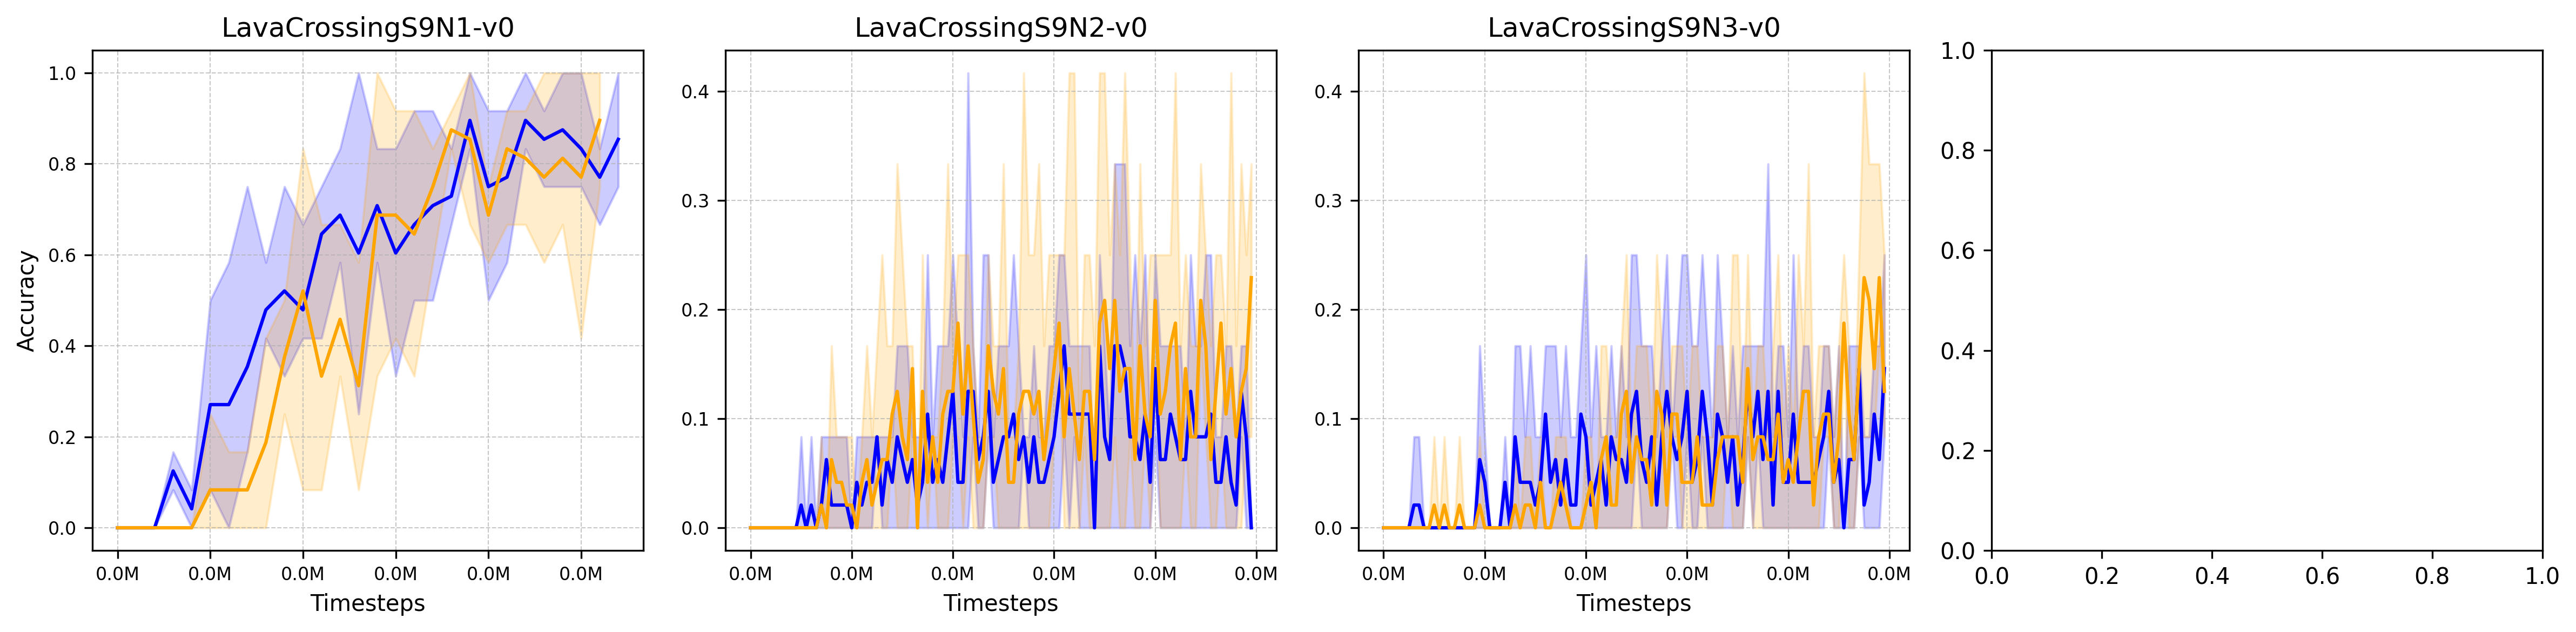

In [39]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Directory where MiniGrid/BabyAI learning data is stored
dir_data = 'models'
envs = [
    "MiniGrid-LavaCrossingS9N1-v0",
    "MiniGrid-LavaCrossingS9N2-v0",
    "MiniGrid-LavaCrossingS9N3-v0",
    "MiniGri[d-LavaCrossingS11N5-v0"
]

# Define colors for different agents
colors = {'ppo': 'b', 'ppo-harmonic': 'orange'}

# Create a figure with 1 row and N columns for subplots
fig, axes = plt.subplots(1, len(envs), figsize=(4 * len(envs), 4), dpi=300)

# Ensure axes is iterable for single environment cases
if len(envs) == 1:
    axes = [axes]  

for i, env in enumerate(envs):
    path = os.path.join(dir_data, env, 'learning_data.pkl')

    if os.path.exists(path):
        with open(path, 'rb') as f:
            results = pickle.load(f)

        for agent in ['ppo', 'ppo-harmonic']:
            train_acc_list = results.get(agent, {}).get('test_acc', [])

            # Convert to NumPy array, handling inconsistent lengths
            train_acc_list = [np.array(run) for run in train_acc_list if isinstance(run, (list, np.ndarray))]
            
            if not train_acc_list:  # Skip if empty
                print(f"Skipping {agent} for {env} (no valid train_acc data)")
                continue

            # Determine minimum length across runs to standardize
            min_length = min(map(len, train_acc_list))

            # Trim all runs to min_length
            train_acc_trimmed = np.array([run[:min_length] for run in train_acc_list])

            # Compute statistics
            mean_acc = np.mean(train_acc_trimmed, axis=0)
            max_acc = np.max(train_acc_trimmed, axis=0)
            min_acc = np.min(train_acc_trimmed, axis=0)

            # Generate x-axis (timesteps)
            timesteps = np.arange(len(mean_acc))

            # Plot mean accuracy
            axes[i].plot(timesteps, mean_acc, label=f'{agent.upper()} Mean', color=colors[agent])

            # Fill the area between min and max values
            axes[i].fill_between(timesteps, min_acc, max_acc, color=colors[agent], alpha=0.2)

        # Formatting
        axes[i].set_title(env.replace("MiniGrid-", ""), fontsize=12)
        axes[i].set_xlabel("Timesteps", fontsize=10)
        axes[i].tick_params(axis='both', which='major', labelsize=8)
        axes[i].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))  # Convert ticks to M
        axes[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

        if i == 0:
            axes[i].set_ylabel("Accuracy", fontsize=10)
        if i == len(envs) - 1:
            axes[i].legend(fontsize=8, loc='lower right', frameon=False)

# Final layout adjustments
plt.tight_layout()
plt.show()

### Plot

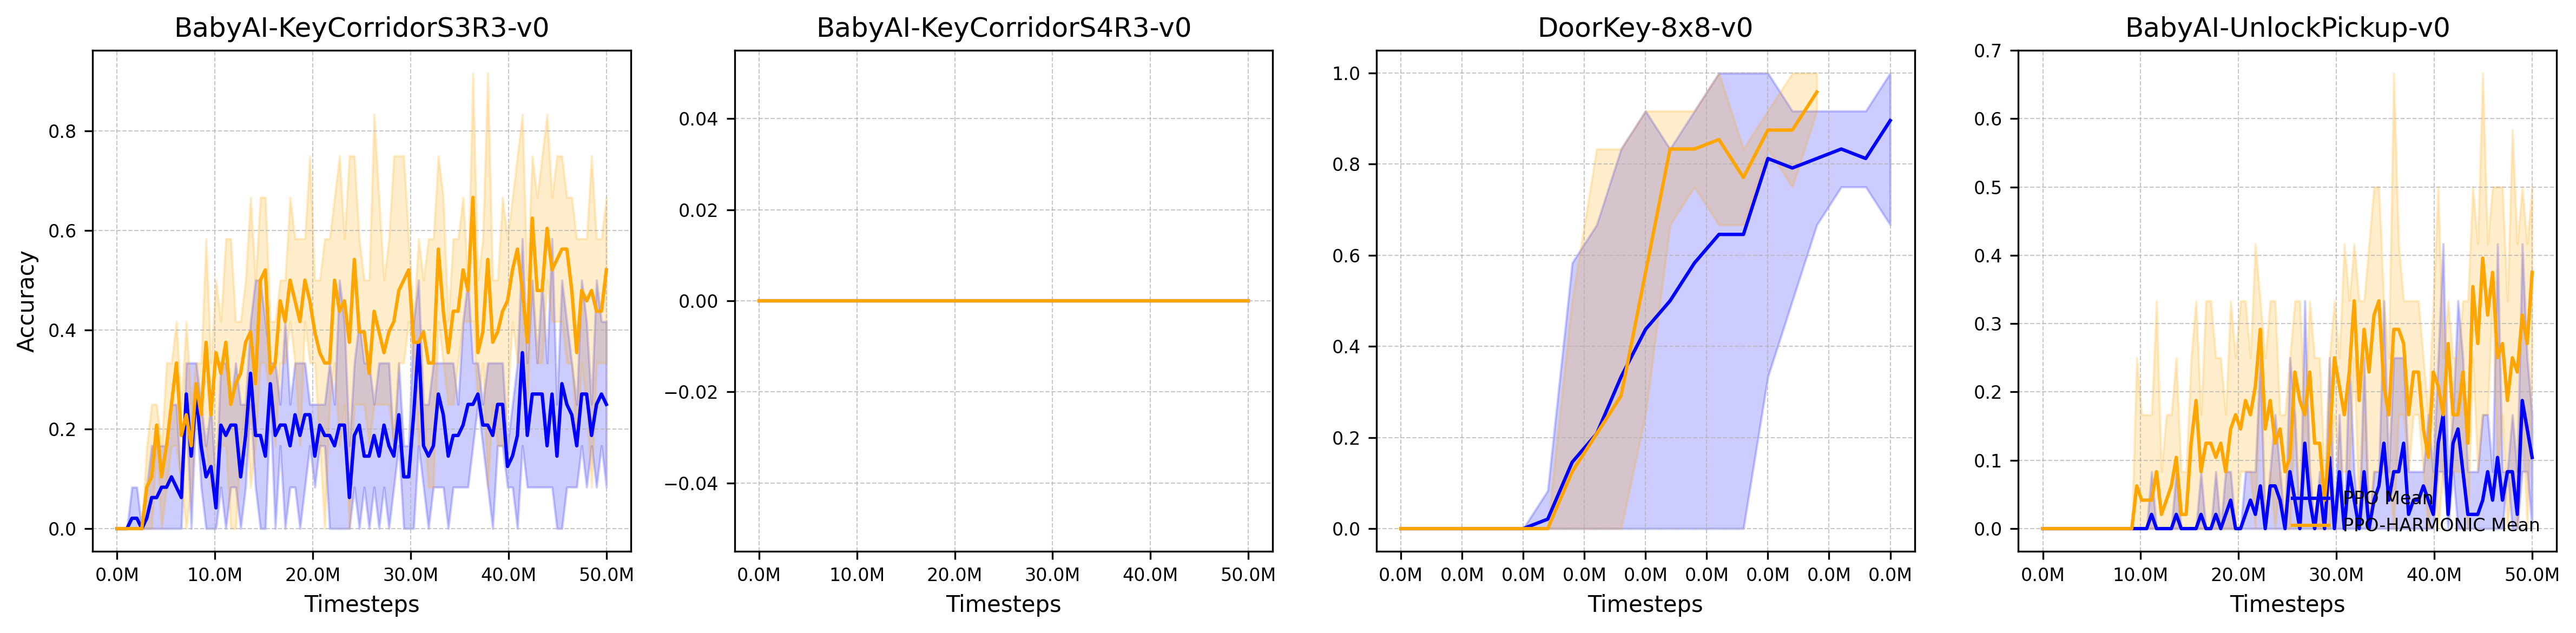

In [15]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Directory where MiniGrid/BabyAI learning data is stored
dir_data = 'models'

envs = [
    'BabyAI-KeyCorridorS3R3-v0',
    'BabyAI-KeyCorridorS4R3-v0',  # no success
    'MiniGrid-DoorKey-8x8-v0',  # Corrected from "MiniGri[d..." and aligned with prior suggestion
    'BabyAI-UnlockPickup-v0'     # Added as the fourth similar environment
]

# Define colors for different agents
colors = {'ppo': 'b', 'ppo-harmonic': 'orange'}

# Create a figure with 1 row and N columns for subplots
fig, axes = plt.subplots(1, len(envs), figsize=(4 * len(envs), 4), dpi=300)

# Ensure axes is iterable for single environment cases
if len(envs) == 1:
    axes = [axes]  

for i, env in enumerate(envs):
    path = os.path.join(dir_data, env, 'learning_data.pkl')

    if os.path.exists(path):
        with open(path, 'rb') as f:
            results = pickle.load(f)

        for agent in ['ppo', 'ppo-harmonic']:
            train_acc_list = results.get(agent, {}).get('test_acc', [])

            # Convert to NumPy array, handling inconsistent lengths
            train_acc_list = [np.array(run) for run in train_acc_list if isinstance(run, (list, np.ndarray))]
            
            if not train_acc_list:  # Skip if empty
                print(f"Skipping {agent} for {env} (no valid train_acc data)")
                continue

            # Determine minimum length across runs to standardize
            min_length = min(map(len, train_acc_list))

            # Trim all runs to min_length
            train_acc_trimmed = np.array([run[:min_length] for run in train_acc_list])

            # Compute statistics
            mean_acc = np.mean(train_acc_trimmed, axis=0)
            max_acc = np.max(train_acc_trimmed, axis=0)
            min_acc = np.min(train_acc_trimmed, axis=0)

            # Generate x-axis (timesteps)
            timesteps = np.arange(len(mean_acc))
            if len(timesteps) == 100:
                timesteps = np.linspace(0,5*10**7,100)

            # Plot mean accuracy
            axes[i].plot(timesteps, mean_acc, label=f'{agent.upper()} Mean', color=colors[agent])

            # Fill the area between min and max values
            axes[i].fill_between(timesteps, min_acc, max_acc, color=colors[agent], alpha=0.2)

        # Formatting
        axes[i].set_title(env.replace("MiniGrid-", ""), fontsize=12)
        axes[i].set_xlabel("Timesteps", fontsize=10)
        axes[i].tick_params(axis='both', which='major', labelsize=8)
        axes[i].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))  # Convert ticks to M
        axes[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

        if i == 0:
            axes[i].set_ylabel("Accuracy", fontsize=10)
        if i == len(envs) - 1:
            axes[i].legend(fontsize=8, loc='lower right', frameon=False)

# Final layout adjustments
plt.tight_layout()
plt.show()